In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import datasets
import matplotlib.pyplot as plt

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
#display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
#display(HTML("<style>.prompt { display:none !important; }</style>"))



In [119]:
class Dense():

    def __init__(self, sizes, activations, Loss, epochs, metric, learning_rate):
        self.weights =[np.random.randn(sizes[i],sizes[i-1]) for i in range(1, len(sizes))]
        self.biases =  [np.zeros((1, sizes[i])) for i in range(1, len(sizes))]
        self.activations = activations
        self.Loss = Loss
        self.epochs = epochs
        self.metric = metric
        self.learning_rate = learning_rate
        
    def forward(self, inputs):
        x = inputs
        self.activated_layers = [x]
        for w,b, act in zip(self.weights, self.biases, self.activations):
            activation = act.activate(np.dot(x, w.T) + b)
            self.activated_layers.append(activation)
            x = activation
            
            
    def backpropagate(self, y):
        #Input: activated_layers
        #output: Container Gradient dE/dw 
        #Initialize
        sigmas_box = []
        sigma_prime_box = []
    
       #Backprop the error ()
        #1. Compute output layer sigma
        loss_grad = self.Loss.loss_gradient(self.activated_layers[-1], y)
        output_sigma = self.activations[-1].output_layer_sigma(loss_grad, self.activated_layers[-1])
        sigmas_box = [output_sigma]
        #Sigmas of the rest of layers...
        for w,a,o_layer in zip(self.weights[::-1], self.activations[:-1][::-1],self.activated_layers[:-1][::-1]) :
            sigmas_box.append(np.dot(sigmas_box[-1], w) * a.sigma_prime(o_layer))
       
        #Reverse sigma_box    
        sigmas_box.reverse()
        #Biases update
        self.grad_biases = sigmas_box
        #Gradient (dE/dw):
        self.gradients = []
        for a, s in zip(self.activated_layers[:-1], sigmas_box):
            self.gradients.append(np.dot(s.T, a))
        #Nota: al hacerse la multiplicacion de todos los inputs a la vez
        #Igual se mantiene el shape de cada weight pero mientras más
        #Inputs más grandes salen los valores de cada componente de la matriz
        #Por eso después se divide cada weight por el total de inputs (mean)
        # print("Gradients shapes:")
        # for g in gradients:
        #     print(g.shape)
       

    def weight_update(self):
        for w,gw, b, gb in zip(self.weights, self.gradients, self.biases, self.grad_biases):
            w -= (self.learning_rate / len(X))* gw
            b -= (self.learning_rate / len(gb))* np.sum(gb, axis= 0)

        return self.weights, self.biases
        
    
    def predict(self, X,y):
            self.forward(X)
            self.prediction = self.activated_layers[-1]
            #Compute the accuracy
            acc = self.metric.get_accuracy(self.prediction, y)
            print("Predictive accuracy:", acc)


            
    def SGD(self, X,y,x_test, y_test, minibatch_size):
        """Vectorized version of Minibatch Stochastic Gradient Descent"""
        print("Minibatch SGD Training......")
        Losses = [] #saves the loss of each epoch
        for e in range(1, self.epochs + 1):
            #tomar dataset y generar minibatches box
            minibatches = self.minibatch_generator(X,y, minibatch_size)
            Accuracies = []
            for mb in minibatches:
                input = mb[0]
                y_true = np.array(mb[1]).astype(int)
                #Obtener los gradientes del minibatch usando backprop
                self.forward(input)
                self.backpropagate(y_true)
                delta_nw = self.gradients #dC/dw
                delta_nb = self.grad_biases #dC/db
                #Updating the parameters 
                self.weights = [w - (self.learning_rate/ len(mb)) * dw for w,dw in zip(self.weights, delta_nw)]
                self.biases = [b - (self.learning_rate/ len(mb)) * np.sum(db, axis = 0) for b, db in zip(self.biases, delta_nb)]
            
            #Reporte de error y accuracy por epoch...
            #Para evaluar como va se calcula el error del epoch usando todo el dataset como corresponde
            self.forward(X)
            y_output = self.activated_layers[-1]
            error = self.Loss.forward_loss(y_output, y)
            acc = self.metric.get_accuracy(y_output, y)
            Losses.append(error)

            if (e % 100 == 0 ) or (e == self.epochs):
                print("Error epoch {0}: {1}--- Accuracy: {2}".format(e, error, acc))
                print("Accuracy in test set:", self.evaluate_test(x_test, y_test))
        #Plotting
        x_label = np.arange(1, self.epochs +1)
        plt.plot(x_label, Losses)
        plt.show()
                   
        print("Training complete!")         


    def MomentumGD(self, X,y,x_test, y_test, beta = 0.9):
        """Vectorized version"""
        print("Momentum Training......")
        #Parameters initialization
        #Velocities initialization
        Vdw = [np.zeros(w.shape) for w in self.weights]
        Vdb = [np.zeros(b.shape) for b in self.biases]
        Losses = []
        Accuracies = []
        for e in range(1, self.epochs + 1):
                self.forward(X)
                #Calcular el error
                error = self.Loss.forward_loss(self.activated_layers[-1], y)
                acc = self.metric.get_accuracy(self.activated_layers[-1], y)
                #Guardar el error y accuracy
                Losses.append(error)
                Accuracies.append(acc)
                #Obtener los gradientes respectivos usando backprop
                self.backpropagate(y)
                delta_nw = self.gradients #dC/dw
                delta_nb = self.grad_biases #dC/db
                
                #Compute the exp moving averages (velocities)
                Vdw = [beta * vw + self.learning_rate * dnw for vw, dnw in zip(Vdw, delta_nw)]
                Vdb = [beta * vb +  self.learning_rate * dnb.mean() for vb, dnb in zip(Vdb, delta_nb)]
                
                #Update weights and biases using the Velocities
                
                self.weights = [w - vdw for w,vdw in zip(self.weights, Vdw)]
                self.biases = [b - vdb for b, vdb in zip(self.biases, Vdb)]
                ''' print("Weights shapes:")
                for w in self.weights:
                    print(w.shape)
                print("Biases shapes:")
                for b in self.biases:
                    print(b.shape) '''

            #Reporte de error y accuracy por epoch...

                if (e % 100 == 0 ) or (e == self.epochs):
                    print("Error epoch {0}: {1}--- Accuracy: {2}".format(e, error, acc))
                    print("Accuracy in test set:", self.evaluate_test(x_test, y_test))
        
        ##Plotting cost
        print("Initial loss:", Losses[1])
        print("Final loss after {0} iterations: {1}".format(self.epochs, Losses[-1]))
        #Plotting
        x_label = np.arange(1, self.epochs +1)
        plt.plot(x_label, Losses)
        plt.show()
                   
        print("Training complete!") 
    
            
    

    def minibatch_generator(self, X,y, batch_size):
        """"Generates minibatches with no replacement"""
        dataset = list(zip(X,np.array(y)))
        np.random.shuffle(dataset)
        minibatches = [(X[i:i+batch_size], y[i:i+batch_size]) for
                        i in range(0, len(y), batch_size)]
                        
        #si minibatch final es mas chico que el batch size se le mete desde
        #atras inputs hasta completar el tamaño batch size
        if len(minibatches[-1][0]) < batch_size:
            minibatches[-1] = (X[-batch_size:], y[-batch_size:])
            
        return minibatches
    
    def evaluate_test(self, x_test, y_test):
        """Evaluates the model on the test set
        input: x_test, y_test
        output: accuracy"""
        #Forward pass---obtain prediction y_pred
        self.forward(x_test)
        #Evaluate prediction with accuracy
        acc_test = self.metric.get_accuracy(self.activated_layers[-1], y_test)
        #Return accuracy
        return acc_test

        
 
class Relu():
    def activate(self, x):
        self.output = np.maximum(0,x)
        return self.output
    
    def sigma_prime(self, x):
        return 1. * (x > 0)


class Sigmoid():
    def activate(self, x):
        #np.exp - (x - np.max(x, axis = 1, keepdims= True))
        x = np.clip(x, 1e-7, 1 - 1e-7)
        self.output = 1 / (1+ np.exp (- (x - np.max(x, axis = 1, keepdims= True))))
        #self.output = 1 / (1+ np.exp(-x))
        return self.output
    
    def output_layer_sigma(self, loss_gradients, x):
        """en realidad calcula todo el sigma de una vez como dC/da * sigma_prime
        dC/da = loss_gradient"""
        
        self.output_sigma = loss_gradients * self.sigma_prime(x)
        return self.output_sigma
    
    def sigma_prime(self, x):
        return x * (1-x)

class Softmax():
    def activate(self, x):
        #Get unnormalized probs
        exp_values = np.exp(x - np.max(x, axis = 1, keepdims= True))
        #Get normalized probs
        self.output = exp_values / np.sum(exp_values, axis= 1, keepdims= True)
        return self.output
    
    def output_layer_sigma(self, loss_gradients, out_activations):
        """Dado que es complejo multplicar el jacobiano de cada input por
        #su loss_gradient por que el jac es una matrix, se hace aca todo directo y se saca 
        #el output layer sigma = dE/dsigma.dsigma/dz"""
        #Se crea un contenedor donde irá el output_sigma de cada input
        #del tamaño del loss_gradient (dinputs)
        self.output_sigma = np.empty_like(loss_gradients)

        #Tomo uno a uno los Loss_gradientes de cada input y cada
        #softmax activation de la output layer para hacer uno a uno los
        #output_sigmas...
        for index, (single_act, single_loss_grad) in enumerate(zip(out_activations, loss_gradients)):
            single_act = single_act.reshape(-1,1)
            #Calculate jacobian matrix (sigma_prime of softmax)
            jacobian_matrix = np.diagflat(single_act) - np.dot(single_act, single_act.T)
            self.output_sigma[index] = np.dot(jacobian_matrix, single_loss_grad)
        return self.output_sigma

         

    
##Loss Units
class MSE():
    
    #Forward
    def forward_loss(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        labels = len(y_pred[0])                  
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        #return  np.sum((y_pred- y_true)**2, axis=1) / len(y_pred)
        return ((y_pred- y_true)**2).mean()
        
    #Derivative
    def loss_gradient(self, y_pred, y_true): #dE/dact
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        labels = len(y_pred[0])                  
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = (2/len(y_pred)) * (y_pred - y_true)
        return self.dinputs
    
    
class CategoricalCrossEntropyLoss():
    def forward_loss(self, y_pred, y_true):
         #entrega el vector de negative losses de cada sample
         y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7) #recorta para evitar logs mulas
         if len(y_true.shape) == 1: #si el y_true viene en un solo vector de escalares
             #extraigo el valor que tiene el indice indicado en el y_true
             #correspondiente
             correct_confidences = y_pred[range(len(y_pred)), y_true]
        
         if len(y_true.shape) == 2: #matrix
             #lo mismo pero multiplique y sume para obtener el valor
             #que tiene el indice indicado por el y_true (el resto se hace zero
             #al multiplicar)
             correct_confidences = np.sum( y_pred * y_true, axis = 1)
        
         negative_loss_likehoods = -np.log(correct_confidences)

         return np.mean(negative_loss_likehoods)
    
    def loss_gradient(self, dvalues, y_true): #dE/dact
        # Number of samples
        dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs



class Accuracy():
#gets the accuracy of the training stage
    def get_accuracy(self, y_pred, y_true):
        #saca el indice donde esta el valor mas grande
        predictions = np.argmax(y_pred, axis= 1)

        #y_true en formato escalares
        if len(y_true.shape) == 1:
            accuracy = np.mean(predictions == y_true)
        #matrix
        elif len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis= 1)
            accuracy = np.mean(predictions == y_true) #promedia coincidencias de valor de indice

        return accuracy



In [65]:
from sklearn import preprocessing
from sklearn import datasets

iris = datasets.load_iris()
X_iris = iris.data 
y_iris= iris.target


scaler = preprocessing.StandardScaler().fit(X_iris)

X_scaled = scaler.transform(X_iris)

sizes = [4, 10, 3]
EPOCHS = 50
net3 = Dense(sizes, activations = [Relu(), Softmax()], Loss = CategoricalCrossEntropyLoss(),
                 epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.015)


In [193]:
train = pd.read_csv("mnist_train.csv", delimiter= ",")
X = train.iloc[:, 1:]
y = train.iloc[:, 0]

#Loading test set
test = pd.read_csv("mnist_test.csv", delimiter= ",")
x_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# scaler = preprocessing.StandardScaler().fit(X)

# X = scaler.transform(X)
# test_X = scaler.transform( test_X )

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform( X )
x_test = scaler.transform(x_test)


sizes2 = [784,30, 10]
EPOCHS = 50

net1 = Dense(sizes2, activations = [Sigmoid(), Softmax()], Loss = MSE(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.05)
        
net2 = Dense(sizes2, activations = [Sigmoid(), Softmax()], Loss = CategoricalCrossEntropyLoss(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.05)

In [87]:
#Testing predict module

import pandas as pd
path = r"C:\Users\malfaro\Desktop\mae_code\NeuralNetworksMae\datasets\diabetes\diabetes_total_vieja.csv"
path_mac = r"/Users/mauricioalfaro/Documents/mae_code/NeuralNetworksMae/datasets/diabetes/diabetes_total_vieja.csv"

#df = pd.read_csv(path)
df = pd.read_csv(path_mac)


X = df.iloc[:, :-1]
y = df.iloc[:, -1]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

#Scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_test.shape

(154, 8)

In [98]:
sizes2 = [8,80, 2]
EPOCHS = 5000
minibatch_size = 10

net1 = Dense(sizes2, activations = [Sigmoid(), Softmax()], Loss = MSE(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.05)
        
net2 = Dense(sizes2, activations = [Sigmoid(), Softmax()], Loss = CategoricalCrossEntropyLoss(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.05)


y_pred =np.array([[0.3, 0.7], [0.6, 0.4]])
y_true =np.array([[0, 1], [0, 1]])





Momentum Training......
Error epoch 100: 0.45035361219797027--- Accuracy: 0.808695652173913
Accuracy in test set: 0.8311688311688312
Error epoch 200: 0.4375357124545535--- Accuracy: 0.8152173913043478
Accuracy in test set: 0.8181818181818182
Error epoch 300: 0.4241021296675977--- Accuracy: 0.8260869565217391
Accuracy in test set: 0.8246753246753247
Error epoch 400: 0.40925462706205346--- Accuracy: 0.8369565217391305
Accuracy in test set: 0.8181818181818182
Error epoch 500: 0.3968350429256959--- Accuracy: 0.8391304347826087
Accuracy in test set: 0.8376623376623377
Error epoch 600: 0.3866351014230236--- Accuracy: 0.8369565217391305
Accuracy in test set: 0.8311688311688312
Error epoch 700: 0.3794346736984813--- Accuracy: 0.8391304347826087
Accuracy in test set: 0.8311688311688312
Error epoch 800: 0.3726806951255332--- Accuracy: 0.841304347826087
Accuracy in test set: 0.8181818181818182
Error epoch 900: 0.366559266100866--- Accuracy: 0.8434782608695652
Accuracy in test set: 0.8181818181818

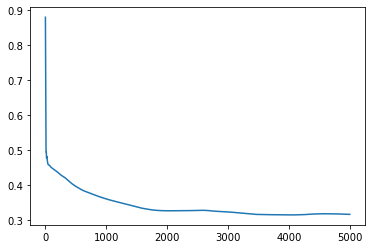

Training complete!


In [99]:
net2.MomentumGD(X_train,y_train,X_test, y_test, minibatch_size, beta = 0.9)
#net2.SGD(X_train,y_train,X_test, y_test, minibatch_size)

In [100]:
net2.predict(X_val, y_val)

Predictive accuracy: 0.7402597402597403


In [12]:
#Mulanic
path = r"C:\Users\malfaro\Desktop\mae_code\NeuralNetworksMae\datasets\breastCancer\breastCancer.csv"

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

#Scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [13]:
sizes2 = [8,30, 2]
EPOCHS = 25000
minibatch_size = 10

net1 = Dense(sizes2, activations = [Sigmoid(), Softmax()], Loss = MSE(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.05)
        
net2 = Dense(sizes2, activations = [Sigmoid(), Softmax()], Loss = CategoricalCrossEntropyLoss(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.005)

In [14]:
net1.SGD(X_train,y_train,X_test, y_test, minibatch_size)
print("Validation...")
print("------------------------------------------------------------------")
net2.predict(X_val, y_val)

SGD Training......
Average Error epoch 100: 0.02579886782999313---Average Accuracy: 0.8195652173913043
Error booster: 0.07727482044862177
Accuracy in test set: 0.8116883116883117
Average Error epoch 200: 0.02451710191035509---Average Accuracy: 0.8413043478260869
Error booster: 0.06482130517257552
Accuracy in test set: 0.8376623376623377
Average Error epoch 300: 0.023937066560293235---Average Accuracy: 0.8347826086956521
Error booster: 0.06872694109670759
Accuracy in test set: 0.8441558441558441
Average Error epoch 400: 0.023400513498336984---Average Accuracy: 0.8391304347826086
Error booster: 0.0720953670215557
Accuracy in test set: 0.8246753246753247
Average Error epoch 500: 0.022813804836479677---Average Accuracy: 0.8369565217391303
Error booster: 0.07535143677094511
Accuracy in test set: 0.8311688311688312
Average Error epoch 600: 0.022232217780422642---Average Accuracy: 0.8391304347826086
Error booster: 0.07777282036882796
Accuracy in test set: 0.8116883116883117
Average Error epoc

In [101]:
cart_data = np.load("saved_training_data.npy",  allow_pickle=True)

In [102]:
def get_data(data):
    """Splits the generated dataset into X and y for training purposes"""
    X = np.array([data[i][0] for i in range(len(data))])
    y = np.array([data[i][1] for i in range(len(data))])
    return X, y

In [103]:
X, y = get_data(cart_data)

y_t = np.argmax(y)
y_t = []
for i in y:
    y_t.append(np.argmax(i))


X_train, X_test, y_train, y_test = train_test_split(X, np.array(y_t), test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

#Scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# (unique, counts) = np.unique(y_t, return_counts=True)
# frequencies = np.asarray((unique, counts/len(y_t))).T
# frequencies


In [130]:
sizes2 = [4, 128,128, 60, 2]
EPOCHS = 30000
minibatch_size = 10

net1 = Dense(sizes2, activations = [Sigmoid(),Sigmoid(), Softmax()], Loss = MSE(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 3)
        
net2 = Dense(sizes2, activations = [Sigmoid(),Sigmoid(), Sigmoid(), Softmax()], Loss = CategoricalCrossEntropyLoss(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.001)

Momentum Training......
Error epoch 100: 0.7015255029720338--- Accuracy: 0.5014
Accuracy in test set: 0.478
Error epoch 200: 0.6897593227633461--- Accuracy: 0.5256
Accuracy in test set: 0.5102
Error epoch 300: 0.6824456347942299--- Accuracy: 0.556
Accuracy in test set: 0.5406
Error epoch 400: 0.6785343189218118--- Accuracy: 0.5684
Accuracy in test set: 0.5582
Error epoch 500: 0.6769218216659857--- Accuracy: 0.5768
Accuracy in test set: 0.5694
Error epoch 600: 0.6751824124111878--- Accuracy: 0.5814
Accuracy in test set: 0.5734
Error epoch 700: 0.6736594279874627--- Accuracy: 0.5856
Accuracy in test set: 0.5802
Error epoch 800: 0.6724368214595765--- Accuracy: 0.587
Accuracy in test set: 0.5818
Error epoch 900: 0.6715526410443461--- Accuracy: 0.589
Accuracy in test set: 0.585
Error epoch 1000: 0.6707356861757908--- Accuracy: 0.5906
Accuracy in test set: 0.5868
Error epoch 1100: 0.6699406640617531--- Accuracy: 0.5922
Accuracy in test set: 0.5886
Error epoch 1200: 0.6692615632809606--- Accu

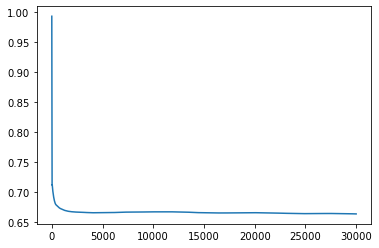

Training complete!


In [131]:
nr = 5000
net2.MomentumGD(X_train[:nr],y_train[:nr],X_test[:nr], y_test[:nr])

In [132]:
net2.predict(X_val, y_val)

Predictive accuracy: 0.5971098104013218


In [134]:
###SAVING THE PARAMETERS FOR TRANSFER LEARNING PROJECTS
trained_weights = net2.weights
trained_biases = net2.biases



import  pickle

with open('mat.pkl', 'wb') as outfile:
    pickle.dump(trained_weights, outfile, pickle.HIGHEST_PROTOCOL)

with open('mat.pkl', 'rb') as infile:
    result_weights= pickle.load(infile)



with open('mat.pkl', 'wb') as outfile:
    pickle.dump(trained_biases, outfile, pickle.HIGHEST_PROTOCOL)

with open('mat.pkl', 'rb') as infile:
    result_biases= pickle.load(infile)

In [135]:
class DenseTransfer():

    def __init__(self, sizes, weights, biases, activations, Loss, epochs, metric, learning_rate):
        self.weights = weights
        self.biases =  biases
        self.activations = activations
        self.Loss = Loss
        self.epochs = epochs
        self.metric = metric
        self.learning_rate = learning_rate
        
    def forward(self, inputs):
        x = inputs
        self.activated_layers = [x]
        for w,b, act in zip(self.weights, self.biases, self.activations):
            activation = act.activate(np.dot(x, w.T) + b)
            self.activated_layers.append(activation)
            x = activation
            
            
    def backpropagate(self, y):
        #Input: activated_layers
        #output: Container Gradient dE/dw 
        #Initialize
        sigmas_box = []
        sigma_prime_box = []
    
       #Backprop the error ()
        #1. Compute output layer sigma
        loss_grad = self.Loss.loss_gradient(self.activated_layers[-1], y)
        output_sigma = self.activations[-1].output_layer_sigma(loss_grad, self.activated_layers[-1])
        sigmas_box = [output_sigma]
        #Sigmas of the rest of layers...
        for w,a,o_layer in zip(self.weights[::-1], self.activations[:-1][::-1],self.activated_layers[:-1][::-1]) :
            sigmas_box.append(np.dot(sigmas_box[-1], w) * a.sigma_prime(o_layer))
       
        #Reverse sigma_box    
        sigmas_box.reverse()
        #Biases update
        self.grad_biases = sigmas_box
        #Gradient (dE/dw):
        self.gradients = []
        for a, s in zip(self.activated_layers[:-1], sigmas_box):
            self.gradients.append(np.dot(s.T, a))
        #Nota: al hacerse la multiplicacion de todos los inputs a la vez
        #Igual se mantiene el shape de cada weight pero mientras más
        #Inputs más grandes salen los valores de cada componente de la matriz
        #Por eso después se divide cada weight por el total de inputs (mean)
        # print("Gradients shapes:")
        # for g in gradients:
        #     print(g.shape)
       

    def weight_update(self):
        for w,gw, b, gb in zip(self.weights, self.gradients, self.biases, self.grad_biases):
            w -= (self.learning_rate / len(X))* gw
            b -= (self.learning_rate / len(gb))* np.sum(gb, axis= 0)

        return self.weights, self.biases
        
    
    def predict(self, X,y):
            self.forward(X)
            self.prediction = self.activated_layers[-1]
            #Compute the accuracy
            acc = self.metric.get_accuracy(self.prediction, y)
            print("Predictive accuracy:", acc)


            
    def SGD(self, X,y,x_test, y_test, minibatch_size):
        """Vectorized version of Minibatch Stochastic Gradient Descent"""
        print("Minibatch SGD Training......")
        Losses = [] #saves the loss of each epoch
        for e in range(1, self.epochs + 1):
            #tomar dataset y generar minibatches box
            minibatches = self.minibatch_generator(X,y, minibatch_size)
            Accuracies = []
            for mb in minibatches:
                input = mb[0]
                y_true = np.array(mb[1]).astype(int)
                #Obtener los gradientes del minibatch usando backprop
                self.forward(input)
                self.backpropagate(y_true)
                delta_nw = self.gradients #dC/dw
                delta_nb = self.grad_biases #dC/db
                #Updating the parameters 
                self.weights = [w - (self.learning_rate/ len(mb)) * dw for w,dw in zip(self.weights, delta_nw)]
                self.biases = [b - (self.learning_rate/ len(mb)) * np.sum(db, axis = 0) for b, db in zip(self.biases, delta_nb)]
            
            #Reporte de error y accuracy por epoch...
            #Para evaluar como va se calcula el error del epoch usando todo el dataset como corresponde
            self.forward(X)
            y_output = self.activated_layers[-1]
            error = self.Loss.forward_loss(y_output, y)
            acc = self.metric.get_accuracy(y_output, y)
            Losses.append(error)

            if (e % 100 == 0 ) or (e == self.epochs):
                print("Error epoch {0}: {1}--- Accuracy: {2}".format(e, error, acc))
                print("Accuracy in test set:", self.evaluate_test(x_test, y_test))
        #Plotting
        x_label = np.arange(1, self.epochs +1)
        plt.plot(x_label, Losses)
        plt.show()
                   
        print("Training complete!")         


    def MomentumGD(self, X,y,x_test, y_test, beta = 0.9):
        """Vectorized version"""
        print("Momentum Training......")
        #Parameters initialization
        #Velocities initialization
        Vdw = [np.zeros(w.shape) for w in self.weights]
        Vdb = [np.zeros(b.shape) for b in self.biases]
        Losses = []
        Accuracies = []
        for e in range(1, self.epochs + 1):
                self.forward(X)
                #Calcular el error
                error = self.Loss.forward_loss(self.activated_layers[-1], y)
                acc = self.metric.get_accuracy(self.activated_layers[-1], y)
                #Guardar el error y accuracy
                Losses.append(error)
                Accuracies.append(acc)
                #Obtener los gradientes respectivos usando backprop
                self.backpropagate(y)
                delta_nw = self.gradients #dC/dw
                delta_nb = self.grad_biases #dC/db
                
                #Compute the exp moving averages (velocities)
                Vdw = [beta * vw + self.learning_rate * dnw for vw, dnw in zip(Vdw, delta_nw)]
                Vdb = [beta * vb +  self.learning_rate * dnb.mean() for vb, dnb in zip(Vdb, delta_nb)]
                
                #Update weights and biases using the Velocities
                
                self.weights = [w - vdw for w,vdw in zip(self.weights, Vdw)]
                self.biases = [b - vdb for b, vdb in zip(self.biases, Vdb)]
                ''' print("Weights shapes:")
                for w in self.weights:
                    print(w.shape)
                print("Biases shapes:")
                for b in self.biases:
                    print(b.shape) '''

            #Reporte de error y accuracy por epoch...

                if (e % 100 == 0 ) or (e == self.epochs):
                    print("Error epoch {0}: {1}--- Accuracy: {2}".format(e, error, acc))
                    print("Accuracy in test set:", self.evaluate_test(x_test, y_test))
        
        ##Plotting cost
        print("Initial loss:", Losses[1])
        print("Final loss after {0} iterations: {1}".format(self.epochs, Losses[-1]))
        #Plotting
        x_label = np.arange(1, self.epochs +1)
        plt.plot(x_label, Losses)
        plt.show()
                   
        print("Training complete!") 
    
            
    

    def minibatch_generator(self, X,y, batch_size):
        """"Generates minibatches with no replacement"""
        dataset = list(zip(X,np.array(y)))
        np.random.shuffle(dataset)
        minibatches = [(X[i:i+batch_size], y[i:i+batch_size]) for
                        i in range(0, len(y), batch_size)]
                        
        #si minibatch final es mas chico que el batch size se le mete desde
        #atras inputs hasta completar el tamaño batch size
        if len(minibatches[-1][0]) < batch_size:
            minibatches[-1] = (X[-batch_size:], y[-batch_size:])
            
        return minibatches
    
    def evaluate_test(self, x_test, y_test):
        """Evaluates the model on the test set
        input: x_test, y_test
        output: accuracy"""
        #Forward pass---obtain prediction y_pred
        self.forward(x_test)
        #Evaluate prediction with accuracy
        acc_test = self.metric.get_accuracy(self.activated_layers[-1], y_test)
        #Return accuracy
        return acc_test

        
 
class Relu():
    def activate(self, x):
        self.output = np.maximum(0,x)
        return self.output
    
    def sigma_prime(self, x):
        return 1. * (x > 0)


class Sigmoid():
    def activate(self, x):
        #np.exp - (x - np.max(x, axis = 1, keepdims= True))
        x = np.clip(x, 1e-7, 1 - 1e-7)
        self.output = 1 / (1+ np.exp (- (x - np.max(x, axis = 1, keepdims= True))))
        #self.output = 1 / (1+ np.exp(-x))
        return self.output
    
    def output_layer_sigma(self, loss_gradients, x):
        """en realidad calcula todo el sigma de una vez como dC/da * sigma_prime
        dC/da = loss_gradient"""
        
        self.output_sigma = loss_gradients * self.sigma_prime(x)
        return self.output_sigma
    
    def sigma_prime(self, x):
        return x * (1-x)

class Softmax():
    def activate(self, x):
        #Get unnormalized probs
        exp_values = np.exp(x - np.max(x, axis = 1, keepdims= True))
        #Get normalized probs
        self.output = exp_values / np.sum(exp_values, axis= 1, keepdims= True)
        return self.output
    
    def output_layer_sigma(self, loss_gradients, out_activations):
        """Dado que es complejo multplicar el jacobiano de cada input por
        #su loss_gradient por que el jac es una matrix, se hace aca todo directo y se saca 
        #el output layer sigma = dE/dsigma.dsigma/dz"""
        #Se crea un contenedor donde irá el output_sigma de cada input
        #del tamaño del loss_gradient (dinputs)
        self.output_sigma = np.empty_like(loss_gradients)

        #Tomo uno a uno los Loss_gradientes de cada input y cada
        #softmax activation de la output layer para hacer uno a uno los
        #output_sigmas...
        for index, (single_act, single_loss_grad) in enumerate(zip(out_activations, loss_gradients)):
            single_act = single_act.reshape(-1,1)
            #Calculate jacobian matrix (sigma_prime of softmax)
            jacobian_matrix = np.diagflat(single_act) - np.dot(single_act, single_act.T)
            self.output_sigma[index] = np.dot(jacobian_matrix, single_loss_grad)
        return self.output_sigma

         

    
##Loss Units
class MSE():
    
    #Forward
    def forward_loss(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        labels = len(y_pred[0])                  
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        #return  np.sum((y_pred- y_true)**2, axis=1) / len(y_pred)
        return ((y_pred- y_true)**2).mean()
        
    #Derivative
    def loss_gradient(self, y_pred, y_true): #dE/dact
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        labels = len(y_pred[0])                  
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = (2/len(y_pred)) * (y_pred - y_true)
        return self.dinputs
    
    
class CategoricalCrossEntropyLoss():
    def forward_loss(self, y_pred, y_true):
         #entrega el vector de negative losses de cada sample
         y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7) #recorta para evitar logs mulas
         if len(y_true.shape) == 1: #si el y_true viene en un solo vector de escalares
             #extraigo el valor que tiene el indice indicado en el y_true
             #correspondiente
             correct_confidences = y_pred[range(len(y_pred)), y_true]
        
         if len(y_true.shape) == 2: #matrix
             #lo mismo pero multiplique y sume para obtener el valor
             #que tiene el indice indicado por el y_true (el resto se hace zero
             #al multiplicar)
             correct_confidences = np.sum( y_pred * y_true, axis = 1)
        
         negative_loss_likehoods = -np.log(correct_confidences)

         return np.mean(negative_loss_likehoods)
    
    def loss_gradient(self, dvalues, y_true): #dE/dact
        # Number of samples
        dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs



class Accuracy():
#gets the accuracy of the training stage
    def get_accuracy(self, y_pred, y_true):
        #saca el indice donde esta el valor mas grande
        predictions = np.argmax(y_pred, axis= 1)

        #y_true en formato escalares
        if len(y_true.shape) == 1:
            accuracy = np.mean(predictions == y_true)
        #matrix
        elif len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis= 1)
            accuracy = np.mean(predictions == y_true) #promedia coincidencias de valor de indice

        return accuracy



In [161]:
###Testing transfer learning engine
sizes2 = [4, 128,128, 60, 2]
EPOCHS = 20000
minibatch_size = 10

net1 = DenseTransfer(sizes2, trained_weights, trained_biases, activations = [Sigmoid(),Sigmoid(), Softmax()], Loss = MSE(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 3)
        
net2 = DenseTransfer(sizes2, trained_weights, trained_biases, activations = [Sigmoid(),Sigmoid(), Sigmoid(), Softmax()], Loss = CategoricalCrossEntropyLoss(),
            epochs = EPOCHS, metric = Accuracy(), learning_rate = 0.15)

Momentum Training......
Error epoch 100: 0.6620954079466658--- Accuracy: 0.6076
Accuracy in test set: 0.5934
Error epoch 200: 0.6615583161762326--- Accuracy: 0.6056
Accuracy in test set: 0.5946
Error epoch 300: 0.6645085426745311--- Accuracy: 0.6082
Accuracy in test set: 0.6
Error epoch 400: 0.6650242986450349--- Accuracy: 0.6054
Accuracy in test set: 0.6
Error epoch 500: 0.665864572589857--- Accuracy: 0.6018
Accuracy in test set: 0.6016
Error epoch 600: 0.6646715180164212--- Accuracy: 0.5978
Accuracy in test set: 0.6006
Error epoch 700: 0.6624233224962278--- Accuracy: 0.6084
Accuracy in test set: 0.6028
Error epoch 800: 0.6626231811207818--- Accuracy: 0.6068
Accuracy in test set: 0.5988
Error epoch 900: 0.66448122601824--- Accuracy: 0.6026
Accuracy in test set: 0.606
Error epoch 1000: 0.6652966289915389--- Accuracy: 0.605
Accuracy in test set: 0.6008
Error epoch 1100: 0.6674281397130051--- Accuracy: 0.5986
Accuracy in test set: 0.5962
Error epoch 1200: 0.6642686151252021--- Accuracy: 

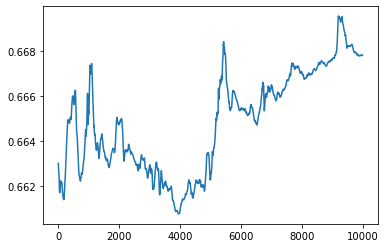

Training complete!


In [159]:
nr = 5000
net2.MomentumGD(X_train[:nr],y_train[:nr],X_test[:nr], y_test[:nr])

In [162]:
trained_weights = net2.weights
trained_biases = net2.biases

nr = 5000
net2.MomentumGD(X_train[:nr],y_train[:nr],X_test[:nr], y_test[:nr])

Momentum Training......
Error epoch 100: 0.6678560485131635--- Accuracy: 0.6088
Accuracy in test set: 0.6052
Error epoch 200: 0.6681114792151253--- Accuracy: 0.608
Accuracy in test set: 0.6064
Error epoch 300: 0.6682995470979187--- Accuracy: 0.6086
Accuracy in test set: 0.6058
Error epoch 400: 0.6678223245285926--- Accuracy: 0.6102
Accuracy in test set: 0.6048
Error epoch 500: 0.6677797258044441--- Accuracy: 0.6104
Accuracy in test set: 0.6054
Error epoch 600: 0.6675810710385842--- Accuracy: 0.61
Accuracy in test set: 0.6056
Error epoch 700: 0.6677424706508679--- Accuracy: 0.61
Accuracy in test set: 0.6056
Error epoch 800: 0.6677302837959349--- Accuracy: 0.6098
Accuracy in test set: 0.6052
Error epoch 900: 0.6680588518616465--- Accuracy: 0.6092
Accuracy in test set: 0.6054
Error epoch 1000: 0.6681723868985169--- Accuracy: 0.6094
Accuracy in test set: 0.6054
Error epoch 1100: 0.6684204680027547--- Accuracy: 0.6096
Accuracy in test set: 0.6052
Error epoch 1200: 0.6676817102973144--- Accu

KeyboardInterrupt: 

In [165]:
import gym
import random
# import numpy as np
# import tflearn
# from tflearn.layers.core import input_data, dropout, fully_connected
# from tflearn.layers.estimator import regression
# from statistics import median, mean
# from collections import Counter

LR = 1e-3
env = gym.make("CartPole-v0")
env.reset()


array([ 0.02276468, -0.00950927,  0.04026177,  0.0336648 ], dtype=float32)

In [179]:
scores = []
choices = []
goal_steps = 200
score_requirement = 50
for each_game in range(5500):
    score = 0
    game_memory = []
    prev_obs = []
    env.reset()
    for _ in range(goal_steps):
        if len(prev_obs)==0:
            action = random.randrange(0,2)
        else:
            net2.forward(prev_obs)
            action = np.argmax(net2.activated_layers[-1])

        choices.append(action)
                
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        
        game_memory.append([new_observation, action])
        score+=reward
        if done: break

    scores.append(score)

print('Average Score:',sum(scores)/len(scores))
print('choice 1:{}  choice 0:{}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
print(score_requirement)

Average Score: 184.6921818181818
choice 1:0.508144755844368  choice 0:0.4918552441556319
50
